Реализация равномерной схемы крест в лагранжевых координатах

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [102]:
def z_to_t(z):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

def t_to_z(t):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    h = 0.674
    R = 3.0856776*1e18 # [cm] 1pc
    return ((Omega_L/Omega_M)**(1/3)*(np.sinh(t/(3.17*1e-14)
            *3*np.sqrt(Omega_L)/2*(h*100*1e5/(R*1e6))))**(-2/3) - 1)

def edd_light_estim(M_pbh,x,r):
    # с = 2.99792458*1e10          # [sm/s]
    # M_sun = 1.98847*1e33 # [g] solar mass
    # sigma_scat = 6.6524587321e-25          # [см**2]
    # L_edd = 10**38*M_pbh/M_sun   # [эрг/с]
    # F = L_edd/(4*np.pi*r**2) # поток
    # return x*M_pbh*10**38*sigma_scat/(M_sun*4*np.pi*c*m_p)/r**2
    # return x*F*sigma_scat/(c*m_p)

    coef = G   # это коэффициент 10**38*sigma_scat/(M_sun*4*np.pi*c*m_p) Здесь он приравнен к грав постоянной так как это следует из предела Эддингтона (если так не сделать то коэффициент будет очень близок: 5.3e-8 вместо 6.6e-8 но эддингтоновский предел не очень воспроизведется)
    return x*coef*M_pbh/r**2

def edd_light(n_H, x, M_pbh, r):
    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]
    H = np.zeros(r.shape[0])
    # H[0] = 1/c*L_edd/(4*np.pi*r[0]**2) # [g/c**2/cm]
    H[0] = G*m_p/sigma_scat*M_pbh/r[0]**2  # здесь преобрахованы коэффициенты для большей точности
    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    for i in range(r.shape[0]-1):
        H[i+1] = (H[i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*sigma_ion*H[i]-n_e[i]*sigma_scat*H[i])) # Для того чтобы получить эддингтоновскую картину нужно закомментировать эту строчку

    return H/m_p*((1-x)*sigma_ion+x*sigma_scat)

def edd_light_multifreq(n_H,x,M_pbh,r):
    E_min = 13.6 # [eV]
    E_max = 10000*1e3 # [eV]
    length_E = 10

    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]
    L_edd = 10**38*M_pbh/M_sun

    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    E_min *= 1.6*1e-12 # [erg]
    E_max *= 1.6*1e-12  # [erg]

    E = np.linspace(E_min,E_max,length_E)
    dE = E[1]-E[0]
    E = np.append(E,E[-1]+dE)

    L = np.zeros(length_E)
    y = lambda E: L_edd/E_max*np.exp(-E/E_max)
    H = np.zeros((length_E,r.shape[0]))

    for i in range(length_E):
        H[i,0] = integrate.quad(y,E[i],E[i+1])[0]      # Здесь сумма (полная светимость) не воспроизводится
    correction_coef = L_edd-np.sum(L)
    L[:] += correction_coef/length_E                    # Поправка делающая светимости равными
    L[:] *= 1/(1-0.20502303)       # Поправка из эддингтоновской оценки

    H[:,0] = 1/c*L/(4*np.pi*r[0]**2)
    right_side = np.zeros((length_E,r.shape[0]))
    k_ion = sigma_ion*(E[:-1]/E_min)**(-3)     # Сечение фотоионизации с учетом энергии налетающего фотона
    for i in range(r.shape[0]-1):
        H[:,i+1] = (H[:,i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*k_ion[:]*H[:,i]-n_e[i]*sigma_scat*H[:,i]))
        right_side[:,i] = H[:,i]/m_p*((1-x[i])*k_ion[:]+x[i]*sigma_scat)       # собираем правую часть уравнения переноса (то что будет стоять в расчете уравнений)
    right_side[:,-1] = H[:,-1]/m_p*((1-x[-1])*k_ion[:]+x[-1]*sigma_scat)
    right_side = np.sum(right_side,0)
    # return np.sum(H,0)/m_p*((1-x)*k_ion+x*sigma_scat)
    return right_side

def acc_light_multifreq(n_H,x,acc_rate,r):
    E_min = 13.6 # [eV]
    E_max = 10000*1e3 # [eV]
    length_E = 10

    sigma_ion = 6e-26                      # [см**2]
    sigma_scat = 6.6524587321e-25          # [см**2]

    rad_efficiency = 1
    L_tot = rad_efficiency * acc_rate * c**2

    x = np.ones(x.shape[0])
    n_e = x * n_H
    n_H_0 = (1-x) * n_H

    E_min *= 1.6*1e-12 # [erg]
    E_max *= 1.6*1e-12  # [erg]

    E = np.linspace(E_min,E_max,length_E)
    dE = E[1]-E[0]
    E = np.append(E,E[-1]+dE)

    L = np.zeros(length_E)
    y = lambda E: L_tot/E_max*np.exp(-E/E_max)
    H = np.zeros((length_E,r.shape[0]))

    for i in range(length_E):
        H[i,0] = integrate.quad(y,E[i],E[i+1])[0]      # Здесь сумма (полная светимость) не воспроизводится
    correction_coef = L_tot-np.sum(L)
    L[:] += correction_coef/length_E                    # Поправка делающая светимости равными
    L[:] *= 1/(1-0.20502303)       # Поправка из эддингтоновской оценки

    H[:,0] = 1/c*L/(4*np.pi*r[0]**2)
    right_side = np.zeros((length_E,r.shape[0]))
    k_ion = sigma_ion*(E[:-1]/E_min)**(-3)     # Сечение фотоионизации с учетом энергии налетающего фотона
    for i in range(r.shape[0]-1):
        H[:,i+1] = (H[:,i]*r[i]**2/r[i+1]**2)
                  # + (r[i+1]/2+r[i]/2)**2*(r[i+1]-r[i])/r[i+1]**2 * (-n_H_0[i]*k_ion[:]*H[:,i]-n_e[i]*sigma_scat*H[:,i]))
        right_side[:,i] = H[:,i]/m_p*((1-x[i])*k_ion[:]+x[i]*sigma_scat)       # собираем правую часть уравнения переноса (то что будет стоять в расчете уравнений)
    right_side[:,-1] = H[:,-1]/m_p*((1-x[-1])*k_ion[:]+x[-1]*sigma_scat)
    right_side = np.sum(right_side,0)
    return right_side

In [103]:
# print(edd_light_multifreq(rho[0,:],x[0,:],M_pbh,r[0,:]))

In [104]:
# print(edd_light_estim(M_pbh,1, r[0,:]))

In [105]:
# print((edd_light_multifreq(rho[0,:]/m_p, x[0,:], M_pbh, r[0,:]) - edd_light_estim(M_pbh,1,r[0,:]))/edd_light_estim(M_pbh,1, r[0,:]))

In [106]:
# (acc_light_multifreq(rho[0,:],x[0,:],acc_rate_edd,r[0,:]) - edd_light_estim(M_pbh,1,r[0,:]))/edd_light_estim(M_pbh,1, r[0,:])

In [107]:
def ioniz_estim(n_H, T):
    m_e = 0.5e6
    delta_H = 13.6
    T_new = T/11604 # температура в эВ
    if np.any((T_new<=0.02)):
        for i in range(T_new.shape[0]):
            if T_new[i]<=0.02:
                T_new[i]=0.02
    n_H_new = n_H*(1.2e-6)**3 # концентрация водорода в эВ^-3
    a = n_H_new*np.exp(delta_H/T_new)*(2*np.pi/(m_e*T_new))**(3/2)
    x = (-1 + np.sqrt(1+4*a))/(2*a)
    return x

In [108]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e6*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674
m_p = 1.67262192369e-24 # Масса протона [g]

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr
M_min = 1e6*M_sun
length = 100
M = np.linspace(M_min,100*M_min,length)
dm = M[1] - M[0]

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

In [109]:
rho = np.zeros((2,length))
r = np.zeros((2,length))
V = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
P = np.zeros((2,length))
x = np.zeros((2,length))

In [110]:
# с = 2.99792458*1e10          # [sm/s]
# L_edd = 10**38*M_pbh/M_sun   # [эрг/с]
# acc_rate_edd = L_edd/c**2
# print(acc_rate_edd/M_sun/3.169e-8)

начальные данные

In [111]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
r[0,:] = (M/(4/3*np.pi*rho[0,:]))**(1/3)
V[0,:] = 0*H*r[0,:]
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
P[0,:] = rho[0,:]*kB*T[0,:]/m_p
e[0,:] = 3/2*P[0,:]/rho[0,:]
x[0,:] = ioniz_estim(rho[0,:]/m_p,T[0,:])

dPhi_dr[0,:] = G*M_pbh/r[0,:]**2 + 0*G*M/r[0,:]**2

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

i = 0

L_edd = 10**38*M_pbh/M_sun   # [эрг/с]
acc_rate_edd = L_edd/c**2

#########
# Блок задающий все нужное для оценки темпа аккреции
R_gas = 8.314*1e7  # [erg/K/mol]
mu = 1.007          # [g/mol]
gamma = 1
sof = np.sqrt(gamma*R_gas*T[0,0]/mu)      # speed of sound
bondi_rate = np.pi*np.exp(3/2)*rho[0,0]*G**2*M_pbh**2/sof**3   # bondi accretion rate [g/s]
bondi_rate = bondi_rate/M_sun/3.169e-8     # [M_sun/year]

t_acc = np.zeros(2)
acc_rate = 0
M_accr_new = 0
M_accreted = np.zeros(2)
t_acc_new = 0
i_acc = 0
###########



while t<t_in*20:
    V[i+1,:-1] = V[i,:-1] - dt*dPhi_dr[i,:-1] + 0*dt/dm*(P[i,:-1]-P[i,1:])*r[i,:-1]**2 + dt*acc_light_multifreq(rho[i,:]/m_p,x[i,:],acc_rate_edd,r[i,:])[:-1] #+ dt*edd_light_multifreq(rho[i,:]/m_p,x[i,:],M_pbh,r[i,:])[:-1]
    r[i+1,:-1] = r[i,:-1] + dt*V[i+1,:-1]

    # Граничное условие на бесконечности (опускаем давление)
    V[i+1,-1] = V[i,-1] - dt*dPhi_dr[i,-1] + dt*acc_light_multifreq(rho[i,:]/m_p,x[i,:],acc_rate_edd,r[i,:])[-1] #+ dt*edd_light_multifreq(rho[i,:]/m_p,x[i,:],M_pbh,r[i,:])[-1]
    r[i+1,-1] = r[i,-1] + dt*V[i+1,-1]

    rho[i+1,:-1] = 3*dm/(r[i+1,1:]**3 - r[i+1,:-1]**3)/(4*np.pi)
    rho[i+1,-1] = rho[i+1,-2]

    # Энергия, Давление, Температура
    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))
    T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]

    # Переход на следующий слой
    # Если первый радиус уходит в - то передвигаем сетку на один вправо (масса в центр по идее добавляется автоматически так как мы сдвигаем сетку по M)
    while r[i+1,0]<r[0,0]:
        # разные вещи нужные для оценки скорости аккреции
        M_accr_new = 0
        if M_accreted[-1] == 0:
            M_accr_new += M[0]
        else:
            M_accr_new += dm
        t_acc_new = t
        i_acc = i+1

        # сдвиг сетки
        M = np.append(M[1:],M[-1]+dm)
        rho[i+1,:] = np.append(rho[i+1,1:],rho[i+1,-1])
        r[i+1,:] = np.append(r[i+1,1:], (dm/(4/3*np.pi*rho[i+1,-2]) + r[i+1,-1]**3)**(1/3))
        V[i+1,:] = np.append(V[i+1,1:],(V[i+1,-2] - V[i+1,-1])/(r[i+1,-3]-r[i+1,-2])*(r[i+1,-1]-r[i+1,-2]) + V[i+1,-1])  # здесь индексы r и V смещены тк r обновлен а V еще нет
        e[i+1,:] = np.append(e[i+1,1:], e[i+1,-1])             # аналогично плотности
        T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
        P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]
        print(i+1)

    # оценка скорости аккреции
    if i_acc==i+1:
        t_acc = np.append(t_acc,t_acc_new)
        M_accreted = np.append(M_accreted, M_accr_new)
        #############
        acc_rate = M_accreted[-1]/(t_acc[-1]-t_acc[-2])/M_sun/3.169e-8
        sof = np.sqrt(gamma*R_gas*T[i+1,-1]/mu)
        bondi_rate = np.pi*rho[i+1,-1]*G**2*M_pbh**2/sof**3   # bondi accretion rate [g/s]
        bondi_rate = bondi_rate/M_sun/ 3.169e-8     # [M_sun/year]
        print('our',acc_rate)
        print('bondi', bondi_rate)
        # if V[i+1,0]<0:
        #     acc_rate_2 = 4*np.pi*r[i+1,0]**2*rho[i+1,0]*np.abs(V[i+1,0])
        #     print('acc_rate_2',acc_rate_2/M_sun/3.169e-8)
    ##################

    dPhi_dr[i+1,:] = G*M_pbh/r[i+1,:]**2 + 0*G*M/r[i+1,:]**2
    x[i+1,:] = 1#ioniz_estim(rho[i+1,:]/m_p,T[i+1,:])
    i+=1
    t += dt
    H_new = 2/(3*t)

    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    V = np.vstack([V,np.zeros(length)])
    r = np.vstack([r,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])
    x = np.vstack([x,np.zeros(length)])

1
our 0.058900076538738855
bondi 1.49870662340202


In [112]:
(t-t_in)*3.169e-14

322.75000504450315

In [113]:
t*3.169e-14

339.7279116749351

Отрисовка

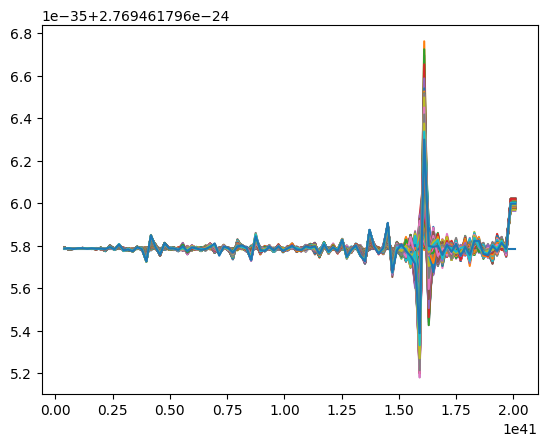

In [114]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 5
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(M[:], rho[i, :])
plt.show()

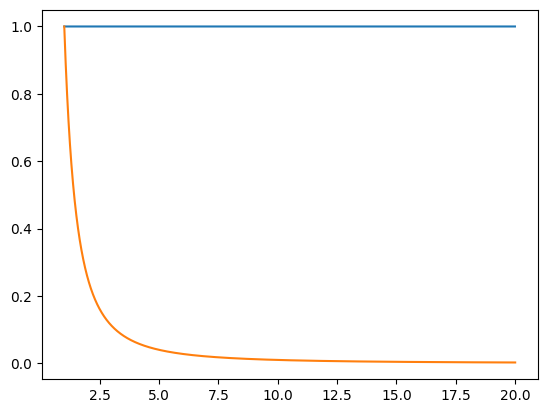

In [115]:
fig, ax = plt.subplots()
hh=1
ax.plot(t_vector[:-hh]/t_vector[0], rho[:-hh-1, 0]/rho[0, -1])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

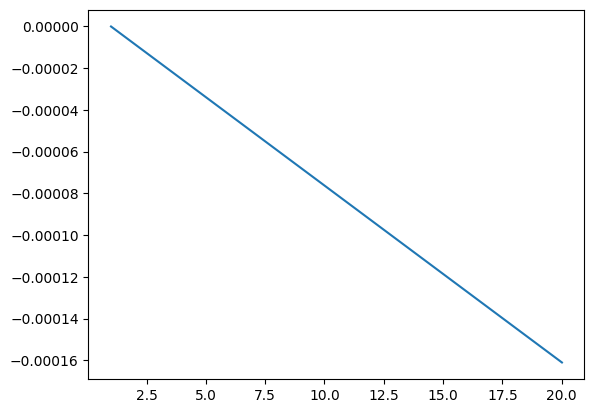

In [116]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, -1])
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.plot(t_vector/t_vector[0],H*r[:-1,-1])

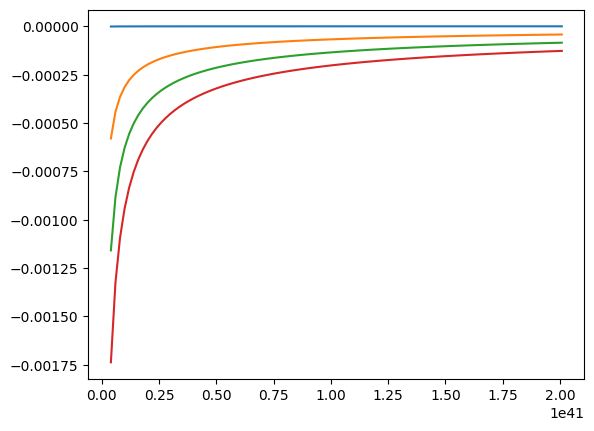

In [117]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 500
for i in range(draw_time_zero, V.shape[0]-2, draw_time_step):
    ax.plot(M[:], V[i+1, :])
plt.show()

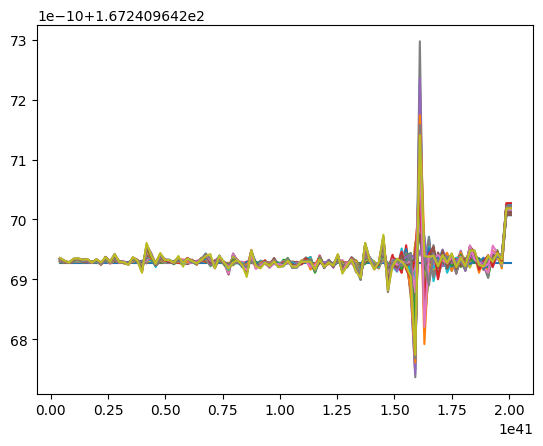

In [118]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(M[:], T[i, :])
plt.show()

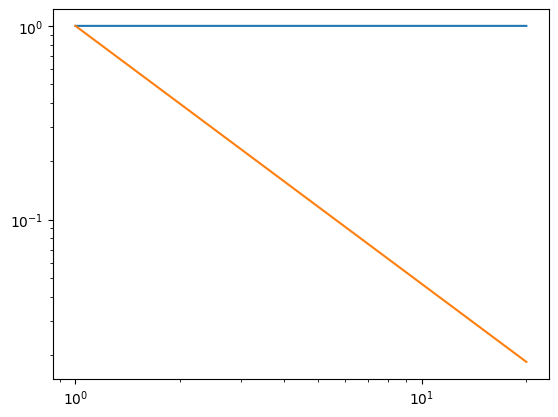

In [119]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))

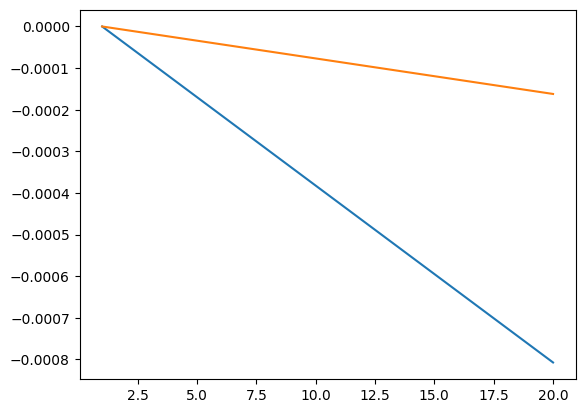

In [120]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, 7])
ax.plot(t_vector/t_vector[0], V[:-1, -2])